In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

In [33]:
#import the data and explore the variables
df = pd.read_csv('ENB2012_data.csv')
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [34]:
#Rename the columns
df.rename(columns={'X1':'Relative Compactness', 
                   'X2':'Surface Area', 
                   'X3':'Wall Area', 
                   'X4':'Roof Area', 
                   'X5':'Overall Height', 
                   'X6':'Orientation', 
                   'X7':'Glazing Area',
                   'X8':'Glazing Area Distribution',
                   'Y1':'Heating Load', 
                   'Y2':'Cooling Load'},
          inplace=True)
df.describe()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [35]:
#Let's build a few utilities to help make life easier later
def format_output(data): #This will reformat the output variables y1 and y2
    y1=data.pop('Heating Load')
    y1 = np.array(y1)
    y2 = data.pop('Cooling Load')
    y2 = np.array(y2)
    return y1, y2
    
def norm(x): #This will normalize based on standard deviation
    return(x - train_stats['mean']) / train_stats['std']

def plot_diff(y_true, y_pred, title =''): #plotting function
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100,100], [-100,100])
    plt.show()

In [15]:
#perform data splitting for training and performing preprocessing

train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

train_stats.pop('Heating Load')
train_stats.pop('Cooling Load')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

norm_train_X = norm(train)
norm_test_X = norm(test)

In [18]:
#Build the model. this will be a dense model and use a functional approach rather than sequential
#Nodes:   First layer: 64
#         Second layer: 32 (half)
# We'll use the relu activation function 

input_layer = Input(shape = (len(train.columns),))
first_dense = Dense(units='64', activation='relu')(input_layer)
second_dense = Dense(units='64', activation='relu')(first_dense)

y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units ='32', activation='relu')(second_dense)

y2_output = Dense(units ='1', name='y2_output')(third_dense)

model = Model(inputs = input_layer, outputs = [y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 128)          1152        ['input_3[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 128)          16512       ['dense_5[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 64)           8256        ['dense_6[0][0]']                
                                                                                              

In [22]:
#configure parameters for training the model

epochs=500
batch_size = 10
validation_data = (norm_test_X, test_Y)
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001) #use stochasitic gradient descent with eta = 10^-3
#compile the model using mse loss function and metric RMSE
model.compile(optimizer = optimizer,
             loss = {'y1_output':'mse','y2_output':'mse'},
             metrics ={'y1_output': tf.keras.metrics.RootMeanSquaredError(),'y2_output': tf.keras.metrics.RootMeanSquaredError()})

In [23]:
#train the model - call the fitted model history
history = model.fit(norm_train_X, train_Y, epochs = epochs, validation_data = validation_data)

Epoch 1/500
20/20 [==============================] - 1s 11ms/step - loss: 606.9554 - y1_output_loss: 297.9591 - y2_output_loss: 308.9964 - y1_output_root_mean_squared_error: 17.2615 - y2_output_root_mean_squared_error: 17.5783 - val_loss: 65.1676 - val_y1_output_loss: 25.1824 - val_y2_output_loss: 39.9851 - val_y1_output_root_mean_squared_error: 5.0182 - val_y2_output_root_mean_squared_error: 6.3234
Epoch 2/500
20/20 [==============================] - 0s 2ms/step - loss: 50.7988 - y1_output_loss: 23.3480 - y2_output_loss: 27.4508 - y1_output_root_mean_squared_error: 4.8320 - y2_output_root_mean_squared_error: 5.2393 - val_loss: 36.5319 - val_y1_output_loss: 14.6118 - val_y2_output_loss: 21.9201 - val_y1_output_root_mean_squared_error: 3.8225 - val_y2_output_root_mean_squared_error: 4.6819
Epoch 3/500
20/20 [==============================] - 0s 3ms/step - loss: 33.4893 - y1_output_loss: 15.6289 - y2_output_loss: 17.8604 - y1_output_root_mean_squared_error: 3.9533 - y2_output_root_mean_s

Epoch 22/500
20/20 [==============================] - 0s 3ms/step - loss: 19.0137 - y1_output_loss: 8.1308 - y2_output_loss: 10.8829 - y1_output_root_mean_squared_error: 2.8515 - y2_output_root_mean_squared_error: 3.2989 - val_loss: 24.9807 - val_y1_output_loss: 7.3381 - val_y2_output_loss: 17.6426 - val_y1_output_root_mean_squared_error: 2.7089 - val_y2_output_root_mean_squared_error: 4.2003
Epoch 23/500
20/20 [==============================] - 0s 2ms/step - loss: 22.2028 - y1_output_loss: 9.0364 - y2_output_loss: 13.1664 - y1_output_root_mean_squared_error: 3.0061 - y2_output_root_mean_squared_error: 3.6286 - val_loss: 15.8968 - val_y1_output_loss: 6.2266 - val_y2_output_loss: 9.6701 - val_y1_output_root_mean_squared_error: 2.4953 - val_y2_output_root_mean_squared_error: 3.1097
Epoch 24/500
20/20 [==============================] - 0s 2ms/step - loss: 18.8579 - y1_output_loss: 8.2295 - y2_output_loss: 10.6283 - y1_output_root_mean_squared_error: 2.8687 - y2_output_root_mean_squared_er

Epoch 43/500
20/20 [==============================] - 0s 3ms/step - loss: 14.7483 - y1_output_loss: 6.5418 - y2_output_loss: 8.2066 - y1_output_root_mean_squared_error: 2.5577 - y2_output_root_mean_squared_error: 2.8647 - val_loss: 12.4460 - val_y1_output_loss: 4.5179 - val_y2_output_loss: 7.9281 - val_y1_output_root_mean_squared_error: 2.1255 - val_y2_output_root_mean_squared_error: 2.8157
Epoch 44/500
20/20 [==============================] - 0s 2ms/step - loss: 15.7954 - y1_output_loss: 6.7078 - y2_output_loss: 9.0876 - y1_output_root_mean_squared_error: 2.5899 - y2_output_root_mean_squared_error: 3.0146 - val_loss: 13.6267 - val_y1_output_loss: 4.5104 - val_y2_output_loss: 9.1163 - val_y1_output_root_mean_squared_error: 2.1238 - val_y2_output_root_mean_squared_error: 3.0193
Epoch 45/500
20/20 [==============================] - 0s 2ms/step - loss: 14.3064 - y1_output_loss: 6.3104 - y2_output_loss: 7.9960 - y1_output_root_mean_squared_error: 2.5121 - y2_output_root_mean_squared_error:

Epoch 64/500
20/20 [==============================] - 0s 3ms/step - loss: 12.4793 - y1_output_loss: 5.0814 - y2_output_loss: 7.3979 - y1_output_root_mean_squared_error: 2.2542 - y2_output_root_mean_squared_error: 2.7199 - val_loss: 9.7029 - val_y1_output_loss: 3.0993 - val_y2_output_loss: 6.6037 - val_y1_output_root_mean_squared_error: 1.7605 - val_y2_output_root_mean_squared_error: 2.5698
Epoch 65/500
20/20 [==============================] - 0s 2ms/step - loss: 11.1798 - y1_output_loss: 4.7959 - y2_output_loss: 6.3840 - y1_output_root_mean_squared_error: 2.1899 - y2_output_root_mean_squared_error: 2.5267 - val_loss: 10.8877 - val_y1_output_loss: 3.3538 - val_y2_output_loss: 7.5339 - val_y1_output_root_mean_squared_error: 1.8313 - val_y2_output_root_mean_squared_error: 2.7448
Epoch 66/500
20/20 [==============================] - 0s 2ms/step - loss: 10.4207 - y1_output_loss: 4.7041 - y2_output_loss: 5.7165 - y1_output_root_mean_squared_error: 2.1689 - y2_output_root_mean_squared_error: 

Epoch 85/500
20/20 [==============================] - 0s 3ms/step - loss: 8.8533 - y1_output_loss: 3.5612 - y2_output_loss: 5.2921 - y1_output_root_mean_squared_error: 1.8871 - y2_output_root_mean_squared_error: 2.3005 - val_loss: 10.5949 - val_y1_output_loss: 3.1763 - val_y2_output_loss: 7.4187 - val_y1_output_root_mean_squared_error: 1.7822 - val_y2_output_root_mean_squared_error: 2.7237
Epoch 86/500
20/20 [==============================] - 0s 2ms/step - loss: 9.3511 - y1_output_loss: 3.7799 - y2_output_loss: 5.5712 - y1_output_root_mean_squared_error: 1.9442 - y2_output_root_mean_squared_error: 2.3603 - val_loss: 11.6451 - val_y1_output_loss: 3.3555 - val_y2_output_loss: 8.2896 - val_y1_output_root_mean_squared_error: 1.8318 - val_y2_output_root_mean_squared_error: 2.8792
Epoch 87/500
20/20 [==============================] - 0s 3ms/step - loss: 9.6905 - y1_output_loss: 3.7560 - y2_output_loss: 5.9345 - y1_output_root_mean_squared_error: 1.9380 - y2_output_root_mean_squared_error: 2.

Epoch 106/500
20/20 [==============================] - 0s 2ms/step - loss: 8.8005 - y1_output_loss: 3.1292 - y2_output_loss: 5.6713 - y1_output_root_mean_squared_error: 1.7690 - y2_output_root_mean_squared_error: 2.3814 - val_loss: 7.1073 - val_y1_output_loss: 2.1911 - val_y2_output_loss: 4.9162 - val_y1_output_root_mean_squared_error: 1.4802 - val_y2_output_root_mean_squared_error: 2.2173
Epoch 107/500
20/20 [==============================] - 0s 3ms/step - loss: 6.4418 - y1_output_loss: 2.5308 - y2_output_loss: 3.9110 - y1_output_root_mean_squared_error: 1.5909 - y2_output_root_mean_squared_error: 1.9776 - val_loss: 16.0501 - val_y1_output_loss: 4.7286 - val_y2_output_loss: 11.3215 - val_y1_output_root_mean_squared_error: 2.1745 - val_y2_output_root_mean_squared_error: 3.3647
Epoch 108/500
20/20 [==============================] - 0s 2ms/step - loss: 7.4716 - y1_output_loss: 2.8553 - y2_output_loss: 4.6162 - y1_output_root_mean_squared_error: 1.6898 - y2_output_root_mean_squared_error:

Epoch 127/500
20/20 [==============================] - 0s 2ms/step - loss: 6.3461 - y1_output_loss: 2.2023 - y2_output_loss: 4.1438 - y1_output_root_mean_squared_error: 1.4840 - y2_output_root_mean_squared_error: 2.0356 - val_loss: 7.6595 - val_y1_output_loss: 1.9345 - val_y2_output_loss: 5.7249 - val_y1_output_root_mean_squared_error: 1.3909 - val_y2_output_root_mean_squared_error: 2.3927
Epoch 128/500
20/20 [==============================] - 0s 3ms/step - loss: 5.9933 - y1_output_loss: 2.0803 - y2_output_loss: 3.9130 - y1_output_root_mean_squared_error: 1.4423 - y2_output_root_mean_squared_error: 1.9781 - val_loss: 7.4674 - val_y1_output_loss: 1.5610 - val_y2_output_loss: 5.9064 - val_y1_output_root_mean_squared_error: 1.2494 - val_y2_output_root_mean_squared_error: 2.4303
Epoch 129/500
20/20 [==============================] - 0s 2ms/step - loss: 5.3906 - y1_output_loss: 2.0355 - y2_output_loss: 3.3551 - y1_output_root_mean_squared_error: 1.4267 - y2_output_root_mean_squared_error: 1

Epoch 148/500
20/20 [==============================] - 0s 3ms/step - loss: 5.0078 - y1_output_loss: 1.7908 - y2_output_loss: 3.2170 - y1_output_root_mean_squared_error: 1.3382 - y2_output_root_mean_squared_error: 1.7936 - val_loss: 18.3020 - val_y1_output_loss: 1.5502 - val_y2_output_loss: 16.7518 - val_y1_output_root_mean_squared_error: 1.2451 - val_y2_output_root_mean_squared_error: 4.0929
Epoch 149/500
20/20 [==============================] - 0s 2ms/step - loss: 5.2104 - y1_output_loss: 1.7683 - y2_output_loss: 3.4421 - y1_output_root_mean_squared_error: 1.3298 - y2_output_root_mean_squared_error: 1.8553 - val_loss: 5.6215 - val_y1_output_loss: 1.5624 - val_y2_output_loss: 4.0590 - val_y1_output_root_mean_squared_error: 1.2500 - val_y2_output_root_mean_squared_error: 2.0147
Epoch 150/500
20/20 [==============================] - 0s 2ms/step - loss: 5.0210 - y1_output_loss: 1.6781 - y2_output_loss: 3.3428 - y1_output_root_mean_squared_error: 1.2954 - y2_output_root_mean_squared_error:

Epoch 169/500
20/20 [==============================] - 0s 3ms/step - loss: 4.7415 - y1_output_loss: 1.5316 - y2_output_loss: 3.2099 - y1_output_root_mean_squared_error: 1.2376 - y2_output_root_mean_squared_error: 1.7916 - val_loss: 6.0663 - val_y1_output_loss: 1.9046 - val_y2_output_loss: 4.1617 - val_y1_output_root_mean_squared_error: 1.3801 - val_y2_output_root_mean_squared_error: 2.0400
Epoch 170/500
20/20 [==============================] - 0s 2ms/step - loss: 4.5112 - y1_output_loss: 1.5160 - y2_output_loss: 2.9952 - y1_output_root_mean_squared_error: 1.2313 - y2_output_root_mean_squared_error: 1.7307 - val_loss: 14.0533 - val_y1_output_loss: 3.0801 - val_y2_output_loss: 10.9732 - val_y1_output_root_mean_squared_error: 1.7550 - val_y2_output_root_mean_squared_error: 3.3126
Epoch 171/500
20/20 [==============================] - 0s 3ms/step - loss: 5.1865 - y1_output_loss: 1.6652 - y2_output_loss: 3.5213 - y1_output_root_mean_squared_error: 1.2904 - y2_output_root_mean_squared_error:

Epoch 190/500
20/20 [==============================] - 0s 3ms/step - loss: 3.4523 - y1_output_loss: 0.9752 - y2_output_loss: 2.4771 - y1_output_root_mean_squared_error: 0.9875 - y2_output_root_mean_squared_error: 1.5739 - val_loss: 3.8812 - val_y1_output_loss: 0.8495 - val_y2_output_loss: 3.0317 - val_y1_output_root_mean_squared_error: 0.9217 - val_y2_output_root_mean_squared_error: 1.7412
Epoch 191/500
20/20 [==============================] - 0s 2ms/step - loss: 5.0094 - y1_output_loss: 1.3406 - y2_output_loss: 3.6688 - y1_output_root_mean_squared_error: 1.1579 - y2_output_root_mean_squared_error: 1.9154 - val_loss: 4.2870 - val_y1_output_loss: 1.0367 - val_y2_output_loss: 3.2503 - val_y1_output_root_mean_squared_error: 1.0182 - val_y2_output_root_mean_squared_error: 1.8029
Epoch 192/500
20/20 [==============================] - 0s 2ms/step - loss: 3.6094 - y1_output_loss: 1.0001 - y2_output_loss: 2.6092 - y1_output_root_mean_squared_error: 1.0001 - y2_output_root_mean_squared_error: 1

Epoch 211/500
20/20 [==============================] - 0s 2ms/step - loss: 3.2943 - y1_output_loss: 0.8952 - y2_output_loss: 2.3991 - y1_output_root_mean_squared_error: 0.9461 - y2_output_root_mean_squared_error: 1.5489 - val_loss: 11.2319 - val_y1_output_loss: 3.7319 - val_y2_output_loss: 7.5001 - val_y1_output_root_mean_squared_error: 1.9318 - val_y2_output_root_mean_squared_error: 2.7386
Epoch 212/500
20/20 [==============================] - 0s 2ms/step - loss: 3.5468 - y1_output_loss: 1.0655 - y2_output_loss: 2.4813 - y1_output_root_mean_squared_error: 1.0322 - y2_output_root_mean_squared_error: 1.5752 - val_loss: 3.8460 - val_y1_output_loss: 0.8325 - val_y2_output_loss: 3.0135 - val_y1_output_root_mean_squared_error: 0.9124 - val_y2_output_root_mean_squared_error: 1.7359
Epoch 213/500
20/20 [==============================] - 0s 3ms/step - loss: 2.5313 - y1_output_loss: 0.7072 - y2_output_loss: 1.8241 - y1_output_root_mean_squared_error: 0.8410 - y2_output_root_mean_squared_error: 

Epoch 232/500
20/20 [==============================] - 0s 2ms/step - loss: 2.5370 - y1_output_loss: 0.6170 - y2_output_loss: 1.9200 - y1_output_root_mean_squared_error: 0.7855 - y2_output_root_mean_squared_error: 1.3857 - val_loss: 2.7220 - val_y1_output_loss: 0.4854 - val_y2_output_loss: 2.2366 - val_y1_output_root_mean_squared_error: 0.6967 - val_y2_output_root_mean_squared_error: 1.4955
Epoch 233/500
20/20 [==============================] - 0s 3ms/step - loss: 9.7368 - y1_output_loss: 2.5655 - y2_output_loss: 7.1713 - y1_output_root_mean_squared_error: 1.6017 - y2_output_root_mean_squared_error: 2.6779 - val_loss: 5.3195 - val_y1_output_loss: 0.7915 - val_y2_output_loss: 4.5280 - val_y1_output_root_mean_squared_error: 0.8897 - val_y2_output_root_mean_squared_error: 2.1279
Epoch 234/500
20/20 [==============================] - 0s 2ms/step - loss: 2.8172 - y1_output_loss: 0.7009 - y2_output_loss: 2.1163 - y1_output_root_mean_squared_error: 0.8372 - y2_output_root_mean_squared_error: 1

Epoch 253/500
20/20 [==============================] - 0s 2ms/step - loss: 3.1243 - y1_output_loss: 0.6795 - y2_output_loss: 2.4448 - y1_output_root_mean_squared_error: 0.8243 - y2_output_root_mean_squared_error: 1.5636 - val_loss: 4.5750 - val_y1_output_loss: 1.0985 - val_y2_output_loss: 3.4765 - val_y1_output_root_mean_squared_error: 1.0481 - val_y2_output_root_mean_squared_error: 1.8645
Epoch 254/500
20/20 [==============================] - 0s 2ms/step - loss: 2.5509 - y1_output_loss: 0.6269 - y2_output_loss: 1.9240 - y1_output_root_mean_squared_error: 0.7918 - y2_output_root_mean_squared_error: 1.3871 - val_loss: 2.7725 - val_y1_output_loss: 0.4670 - val_y2_output_loss: 2.3054 - val_y1_output_root_mean_squared_error: 0.6834 - val_y2_output_root_mean_squared_error: 1.5184
Epoch 255/500
20/20 [==============================] - 0s 2ms/step - loss: 3.0803 - y1_output_loss: 0.7959 - y2_output_loss: 2.2844 - y1_output_root_mean_squared_error: 0.8922 - y2_output_root_mean_squared_error: 1

Epoch 274/500
20/20 [==============================] - 0s 2ms/step - loss: 5.5764 - y1_output_loss: 1.3080 - y2_output_loss: 4.2684 - y1_output_root_mean_squared_error: 1.1437 - y2_output_root_mean_squared_error: 2.0660 - val_loss: 2.6049 - val_y1_output_loss: 0.5020 - val_y2_output_loss: 2.1029 - val_y1_output_root_mean_squared_error: 0.7085 - val_y2_output_root_mean_squared_error: 1.4501
Epoch 275/500
20/20 [==============================] - 0s 3ms/step - loss: 2.2899 - y1_output_loss: 0.5155 - y2_output_loss: 1.7745 - y1_output_root_mean_squared_error: 0.7180 - y2_output_root_mean_squared_error: 1.3321 - val_loss: 3.1466 - val_y1_output_loss: 0.8105 - val_y2_output_loss: 2.3361 - val_y1_output_root_mean_squared_error: 0.9003 - val_y2_output_root_mean_squared_error: 1.5284
Epoch 276/500
20/20 [==============================] - 0s 2ms/step - loss: 3.4757 - y1_output_loss: 0.8790 - y2_output_loss: 2.5967 - y1_output_root_mean_squared_error: 0.9375 - y2_output_root_mean_squared_error: 1

Epoch 295/500
20/20 [==============================] - 0s 2ms/step - loss: 1.9666 - y1_output_loss: 0.4636 - y2_output_loss: 1.5030 - y1_output_root_mean_squared_error: 0.6809 - y2_output_root_mean_squared_error: 1.2260 - val_loss: 2.3671 - val_y1_output_loss: 0.4919 - val_y2_output_loss: 1.8752 - val_y1_output_root_mean_squared_error: 0.7013 - val_y2_output_root_mean_squared_error: 1.3694
Epoch 296/500
20/20 [==============================] - 0s 2ms/step - loss: 2.4289 - y1_output_loss: 0.5641 - y2_output_loss: 1.8648 - y1_output_root_mean_squared_error: 0.7510 - y2_output_root_mean_squared_error: 1.3656 - val_loss: 14.0903 - val_y1_output_loss: 1.4747 - val_y2_output_loss: 12.6155 - val_y1_output_root_mean_squared_error: 1.2144 - val_y2_output_root_mean_squared_error: 3.5518
Epoch 297/500
20/20 [==============================] - 0s 2ms/step - loss: 3.8333 - y1_output_loss: 0.9488 - y2_output_loss: 2.8845 - y1_output_root_mean_squared_error: 0.9741 - y2_output_root_mean_squared_error:

Epoch 316/500
20/20 [==============================] - 0s 3ms/step - loss: 1.9190 - y1_output_loss: 0.4339 - y2_output_loss: 1.4851 - y1_output_root_mean_squared_error: 0.6587 - y2_output_root_mean_squared_error: 1.2186 - val_loss: 2.9855 - val_y1_output_loss: 0.4398 - val_y2_output_loss: 2.5456 - val_y1_output_root_mean_squared_error: 0.6632 - val_y2_output_root_mean_squared_error: 1.5955
Epoch 317/500
20/20 [==============================] - 0s 2ms/step - loss: 1.7211 - y1_output_loss: 0.3785 - y2_output_loss: 1.3426 - y1_output_root_mean_squared_error: 0.6152 - y2_output_root_mean_squared_error: 1.1587 - val_loss: 4.9407 - val_y1_output_loss: 0.7450 - val_y2_output_loss: 4.1957 - val_y1_output_root_mean_squared_error: 0.8631 - val_y2_output_root_mean_squared_error: 2.0483
Epoch 318/500
20/20 [==============================] - 0s 2ms/step - loss: 2.3238 - y1_output_loss: 0.6003 - y2_output_loss: 1.7234 - y1_output_root_mean_squared_error: 0.7748 - y2_output_root_mean_squared_error: 1

Epoch 337/500
20/20 [==============================] - 0s 2ms/step - loss: 2.2266 - y1_output_loss: 0.5108 - y2_output_loss: 1.7158 - y1_output_root_mean_squared_error: 0.7147 - y2_output_root_mean_squared_error: 1.3099 - val_loss: 3.6458 - val_y1_output_loss: 1.4079 - val_y2_output_loss: 2.2379 - val_y1_output_root_mean_squared_error: 1.1865 - val_y2_output_root_mean_squared_error: 1.4960
Epoch 338/500
20/20 [==============================] - 0s 3ms/step - loss: 3.1640 - y1_output_loss: 0.7153 - y2_output_loss: 2.4487 - y1_output_root_mean_squared_error: 0.8458 - y2_output_root_mean_squared_error: 1.5648 - val_loss: 2.7224 - val_y1_output_loss: 0.5395 - val_y2_output_loss: 2.1828 - val_y1_output_root_mean_squared_error: 0.7345 - val_y2_output_root_mean_squared_error: 1.4774
Epoch 339/500
20/20 [==============================] - 0s 2ms/step - loss: 1.8615 - y1_output_loss: 0.4117 - y2_output_loss: 1.4498 - y1_output_root_mean_squared_error: 0.6417 - y2_output_root_mean_squared_error: 1

Epoch 358/500
20/20 [==============================] - 0s 2ms/step - loss: 1.5833 - y1_output_loss: 0.3474 - y2_output_loss: 1.2359 - y1_output_root_mean_squared_error: 0.5894 - y2_output_root_mean_squared_error: 1.1117 - val_loss: 2.7087 - val_y1_output_loss: 0.7516 - val_y2_output_loss: 1.9571 - val_y1_output_root_mean_squared_error: 0.8669 - val_y2_output_root_mean_squared_error: 1.3990
Epoch 359/500
20/20 [==============================] - 0s 3ms/step - loss: 2.0226 - y1_output_loss: 0.3541 - y2_output_loss: 1.6685 - y1_output_root_mean_squared_error: 0.5951 - y2_output_root_mean_squared_error: 1.2917 - val_loss: 4.2720 - val_y1_output_loss: 0.9814 - val_y2_output_loss: 3.2906 - val_y1_output_root_mean_squared_error: 0.9906 - val_y2_output_root_mean_squared_error: 1.8140
Epoch 360/500
20/20 [==============================] - 0s 2ms/step - loss: 1.9497 - y1_output_loss: 0.4534 - y2_output_loss: 1.4962 - y1_output_root_mean_squared_error: 0.6734 - y2_output_root_mean_squared_error: 1

Epoch 379/500
20/20 [==============================] - 0s 2ms/step - loss: 1.7981 - y1_output_loss: 0.3788 - y2_output_loss: 1.4192 - y1_output_root_mean_squared_error: 0.6155 - y2_output_root_mean_squared_error: 1.1913 - val_loss: 2.1035 - val_y1_output_loss: 0.3614 - val_y2_output_loss: 1.7421 - val_y1_output_root_mean_squared_error: 0.6012 - val_y2_output_root_mean_squared_error: 1.3199
Epoch 380/500
20/20 [==============================] - 0s 2ms/step - loss: 1.9708 - y1_output_loss: 0.4473 - y2_output_loss: 1.5235 - y1_output_root_mean_squared_error: 0.6688 - y2_output_root_mean_squared_error: 1.2343 - val_loss: 3.2764 - val_y1_output_loss: 0.6508 - val_y2_output_loss: 2.6256 - val_y1_output_root_mean_squared_error: 0.8067 - val_y2_output_root_mean_squared_error: 1.6204
Epoch 381/500
20/20 [==============================] - 0s 2ms/step - loss: 4.1548 - y1_output_loss: 1.0540 - y2_output_loss: 3.1007 - y1_output_root_mean_squared_error: 1.0267 - y2_output_root_mean_squared_error: 1

Epoch 400/500
20/20 [==============================] - 0s 2ms/step - loss: 3.0012 - y1_output_loss: 0.7278 - y2_output_loss: 2.2734 - y1_output_root_mean_squared_error: 0.8531 - y2_output_root_mean_squared_error: 1.5078 - val_loss: 2.2101 - val_y1_output_loss: 0.4120 - val_y2_output_loss: 1.7981 - val_y1_output_root_mean_squared_error: 0.6419 - val_y2_output_root_mean_squared_error: 1.3409
Epoch 401/500
20/20 [==============================] - 0s 3ms/step - loss: 2.7867 - y1_output_loss: 0.6195 - y2_output_loss: 2.1672 - y1_output_root_mean_squared_error: 0.7871 - y2_output_root_mean_squared_error: 1.4721 - val_loss: 2.1711 - val_y1_output_loss: 0.4542 - val_y2_output_loss: 1.7169 - val_y1_output_root_mean_squared_error: 0.6739 - val_y2_output_root_mean_squared_error: 1.3103
Epoch 402/500
20/20 [==============================] - 0s 2ms/step - loss: 2.6196 - y1_output_loss: 0.5792 - y2_output_loss: 2.0405 - y1_output_root_mean_squared_error: 0.7610 - y2_output_root_mean_squared_error: 1

Epoch 421/500
20/20 [==============================] - 0s 2ms/step - loss: 2.4207 - y1_output_loss: 0.5429 - y2_output_loss: 1.8777 - y1_output_root_mean_squared_error: 0.7368 - y2_output_root_mean_squared_error: 1.3703 - val_loss: 2.4122 - val_y1_output_loss: 0.4483 - val_y2_output_loss: 1.9639 - val_y1_output_root_mean_squared_error: 0.6695 - val_y2_output_root_mean_squared_error: 1.4014
Epoch 422/500
20/20 [==============================] - 0s 2ms/step - loss: 3.6082 - y1_output_loss: 0.7412 - y2_output_loss: 2.8671 - y1_output_root_mean_squared_error: 0.8609 - y2_output_root_mean_squared_error: 1.6932 - val_loss: 23.7532 - val_y1_output_loss: 7.3706 - val_y2_output_loss: 16.3825 - val_y1_output_root_mean_squared_error: 2.7149 - val_y2_output_root_mean_squared_error: 4.0475
Epoch 423/500
20/20 [==============================] - 0s 2ms/step - loss: 4.0400 - y1_output_loss: 0.9714 - y2_output_loss: 3.0686 - y1_output_root_mean_squared_error: 0.9856 - y2_output_root_mean_squared_error:

Epoch 442/500
20/20 [==============================] - 0s 3ms/step - loss: 1.3001 - y1_output_loss: 0.2837 - y2_output_loss: 1.0164 - y1_output_root_mean_squared_error: 0.5326 - y2_output_root_mean_squared_error: 1.0082 - val_loss: 4.8009 - val_y1_output_loss: 0.6610 - val_y2_output_loss: 4.1399 - val_y1_output_root_mean_squared_error: 0.8130 - val_y2_output_root_mean_squared_error: 2.0347
Epoch 443/500
20/20 [==============================] - 0s 2ms/step - loss: 2.5387 - y1_output_loss: 0.5972 - y2_output_loss: 1.9415 - y1_output_root_mean_squared_error: 0.7728 - y2_output_root_mean_squared_error: 1.3934 - val_loss: 2.4176 - val_y1_output_loss: 0.5810 - val_y2_output_loss: 1.8366 - val_y1_output_root_mean_squared_error: 0.7622 - val_y2_output_root_mean_squared_error: 1.3552
Epoch 444/500
20/20 [==============================] - 0s 2ms/step - loss: 1.4648 - y1_output_loss: 0.3300 - y2_output_loss: 1.1348 - y1_output_root_mean_squared_error: 0.5745 - y2_output_root_mean_squared_error: 1

Epoch 463/500
20/20 [==============================] - 0s 3ms/step - loss: 4.4196 - y1_output_loss: 1.0196 - y2_output_loss: 3.4000 - y1_output_root_mean_squared_error: 1.0098 - y2_output_root_mean_squared_error: 1.8439 - val_loss: 2.3881 - val_y1_output_loss: 0.6161 - val_y2_output_loss: 1.7720 - val_y1_output_root_mean_squared_error: 0.7849 - val_y2_output_root_mean_squared_error: 1.3312
Epoch 464/500
20/20 [==============================] - 0s 2ms/step - loss: 1.3895 - y1_output_loss: 0.3210 - y2_output_loss: 1.0685 - y1_output_root_mean_squared_error: 0.5665 - y2_output_root_mean_squared_error: 1.0337 - val_loss: 1.9027 - val_y1_output_loss: 0.3487 - val_y2_output_loss: 1.5540 - val_y1_output_root_mean_squared_error: 0.5905 - val_y2_output_root_mean_squared_error: 1.2466
Epoch 465/500
20/20 [==============================] - 0s 3ms/step - loss: 1.4925 - y1_output_loss: 0.3412 - y2_output_loss: 1.1513 - y1_output_root_mean_squared_error: 0.5841 - y2_output_root_mean_squared_error: 1

Epoch 484/500
20/20 [==============================] - 0s 2ms/step - loss: 1.7811 - y1_output_loss: 0.3942 - y2_output_loss: 1.3869 - y1_output_root_mean_squared_error: 0.6278 - y2_output_root_mean_squared_error: 1.1777 - val_loss: 3.7172 - val_y1_output_loss: 0.9515 - val_y2_output_loss: 2.7658 - val_y1_output_root_mean_squared_error: 0.9754 - val_y2_output_root_mean_squared_error: 1.6631
Epoch 485/500
20/20 [==============================] - 0s 2ms/step - loss: 4.0765 - y1_output_loss: 0.9203 - y2_output_loss: 3.1562 - y1_output_root_mean_squared_error: 0.9593 - y2_output_root_mean_squared_error: 1.7766 - val_loss: 3.7739 - val_y1_output_loss: 0.8338 - val_y2_output_loss: 2.9401 - val_y1_output_root_mean_squared_error: 0.9131 - val_y2_output_root_mean_squared_error: 1.7147
Epoch 486/500
20/20 [==============================] - 0s 3ms/step - loss: 1.1534 - y1_output_loss: 0.2466 - y2_output_loss: 0.9068 - y1_output_root_mean_squared_error: 0.4966 - y2_output_root_mean_squared_error: 0

In [28]:
#Evaluate the model
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y2_loss = {}, Y1_rmse = {}, Y2_rmse = {}".format(loss , Y1_loss, Y2_loss, Y1_rmse, Y2_rmse))

5/5 [==============================] - 0s 1ms/step - loss: 2.7451 - y1_output_loss: 0.3575 - y2_output_loss: 2.3876 - y1_output_root_mean_squared_error: 0.5979 - y2_output_root_mean_squared_error: 1.5452
Loss = 2.745079755783081, Y1_loss = 0.3575162887573242, Y2_loss = 2.3875632286071777, Y1_rmse = 0.597926676273346, Y2_rmse = 1.5451741218566895


5/5 [==============================] - 0s 1ms/step


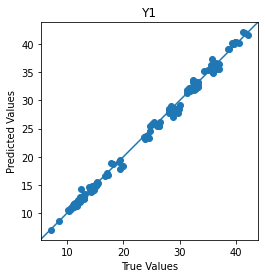

In [36]:
#plot the results
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title ='Y1')

5/5 [==============================] - 0s 3ms/step


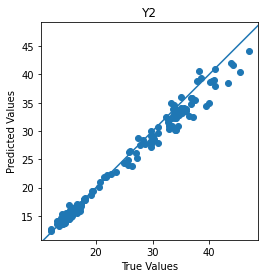

In [37]:
#plot the results
Y_pred = model.predict(norm_test_X)
#Note that we will see some fanning occuring
plot_diff(test_Y[1], Y_pred[1], title ='Y2')